In [5]:
import json
import random
import numpy as np
import tensorflow as tf
from collections import deque
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K
import convert_event_list as convert
import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import time
import math

from matplotlib.colors import LinearSegmentedColormap
import colorsys
import numpy as np
    
from data_retrieval_3ksol import INSTANCEProvider
from kbh_yard_b2b import KBH_Env                               #This is the environment of the shunting yard
from dqn_kbh_colfax_b2b_instances_test_agent import DQNAgent

In [6]:
instances = range(5000,8020)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 33, 32)         16928     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 33, 64)         8256      
_________________________________________________________________
flatten_7 (Flatten)          (None, 2112)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               540928    
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 2313      
Total params: 568,425
Trainable params: 568,425
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv

model loaded
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
Model:  1521138212
   original_length  solved  tried  percentage
0               23     644    755    0.852980
1               26     626    755    0.829139
2               27     645    755    0.854305
3               29     654    755    0.866225


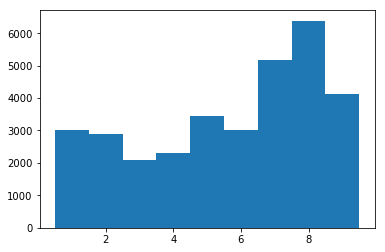

In [7]:
for model_nr in ['1521137844', '1521137935', '1521138059', '1521138212']:
    #which model to load.
    test_case = model_nr
    
    #LOAD THE INSTANCE PROVIDER
    ig = INSTANCEProvider()
    
    # Create environment KBH
    yrd = KBH_Env()

    # Create the DQNAgent with the CNN approximation of the Q-function and its experience replay and training functions.
    # load the trained model.
    agent = DQNAgent(yrd, True, test_case)

    # set epsilon to 0 to act just greedy
    agent.epsilon = 0

    #new_cmap = rand_cmap(200, type='soft', first_color_black=True, last_color_black=False, verbose=True)
    
    visualization = False
    
    n = len(instances)
    
    # result vectors
    original_lengths = []
    terminated_at_step = []
    print_count = 0
    
    
    # train types different tracks? 
    type_step_track = []
    
       
    for instance in instances:
        if print_count % 100 == 0:
            print(print_count)
        print_count = print_count + 1
        #Initialize problem
        event_list = ig.get_instance(instance)
        
        steps = len(event_list)
        if len(event_list) < 60:        
            t = 0
    
            score = 0  # Init score variable for this particular episode.
    
            state = yrd.reset(event_list)  # Get first observation based on the first train arrival.
            history = np.reshape(state, (
                1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape state into tensor, which we call history.
            
            if visualization == True:
                plt.imshow(np.float32(history[0][0]), cmap=new_cmap, interpolation='nearest')
                plt.show()
    
            while t <= steps:
                action = agent.get_action(history)  # RL choose action based on observation
                
                if visualization == True:
                    print(agent.model.predict(history))
                    print(action+1)
                # RL take action and get next observation and reward
                # note the +1 at action
                event_list_temp = event_list.reset_index(drop=True).copy()
                if event_list_temp.event_type[0]=='arrival':
                    train_type = event_list_temp.composition[0]
                    type_step_track.append({'type': train_type, 'action': action+1, 'step':t, 'instance_id': instance})
                    
                raw_observation_, reward, done = yrd.step(action + 1, event_list)
    
                state_ = np.reshape(raw_observation_, (1, yrd.shape[0], yrd.shape[1], yrd.shape[2]))  # reshape to tensor.
                history_ = state_  # this is now the next observation, call it history_
    
                score += reward  # log direct reward of action
                
                
                
                if visualization == True: 
                    #show action
                    plt.imshow(np.float32(history_[0][0]), cmap=new_cmap, interpolation='nearest')
                    plt.show()
                    time.sleep(0.05)
                    if reward == -1:
                        time.sleep(1)
                    print(reward)
                    
                if done:  # based on what the environment returns.
                    #print('ended at step' , t+1)
                    #print('original length', steps)
                    original_lengths.append(steps)
                    terminated_at_step.append(t+1)
                    break;
    
    
                history = history_  # next state now becomes the current state.
                t += 1  # next step in this episode
        else: 
            original_lengths.append(steps)
            terminated_at_step.append(-1)
    
    #compute scores
    df_type_step_track = pd.DataFrame.from_records(type_step_track)
    df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
    df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
    
    analysis_runs = pd.DataFrame(
    {'instance_id': instances,
     'original_length': original_lengths,
     'terminated_at_step': terminated_at_step
    })
 
    analysis_runs['solved'] = analysis_runs.apply(lambda row: 1 if row.original_length == row.terminated_at_step else 0, axis =1 )
    analysis_runs['tried'] = analysis_runs.apply(lambda row: 1 if row.terminated_at_step != -1 else 0, axis =1)
    analysis_runs['percentage'] = analysis_runs.apply(lambda row: row.solved/755, axis=1)
    
    print('Model: ', model_nr)
    summary = analysis_runs.groupby('original_length', as_index=False)[['solved', 'tried', 'percentage']].sum()
    print(summary)
    
    #print hist
    %matplotlib inline  
    #%%
    # analyse the parking actions per step and train type
    df_type_step_track = pd.DataFrame.from_records(type_step_track)
    bins = [1,2,3,4,5,6,7,8,9,10]
    plt.hist(df_type_step_track.action, bins, align='left')
    
    #prepare for save
    df_type_step_track['strtype'] = df_type_step_track.apply(lambda row: str(row.type), axis = 1)
    df_type_step_track.strtype = df_type_step_track.strtype.astype('category')
    filename = 'data_'+model_nr+'_paper.csv'
    df_type_step_track.to_csv(filename)





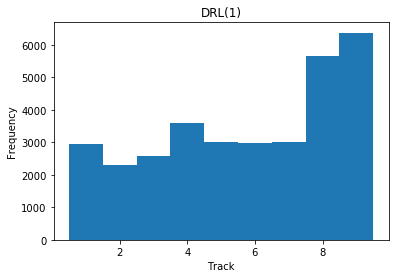

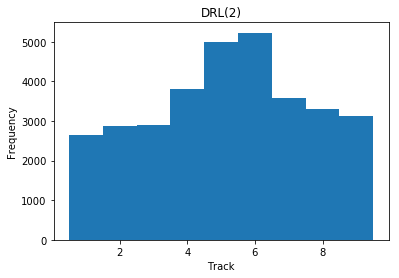

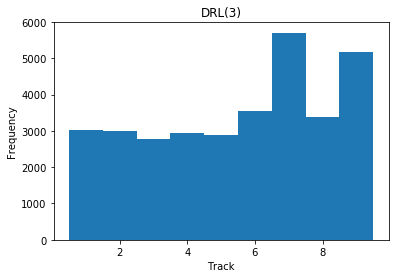

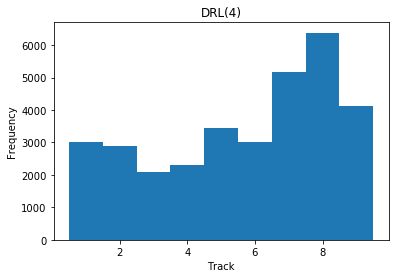

In [18]:
i = 1
for model_nr in ['1521137844', '1521137935', '1521138059', '1521138212']:
    filename = 'data_'+model_nr+'_paper.csv'
    data = pd.DataFrame.from_csv(filename)
    %matplotlib inline  
    #%%
    # analyse the parking actions per step and train type
    bins = [1,2,3,4,5,6,7,8,9,10]
    plt.hist(data.action, bins, align='left')
    plt.title('DRL('+str(i)+')')
    plt.xlabel('Track')
    plt.ylabel('Frequency')
    plt.savefig('fig_'+model_nr+'.png')
    plt.show()
    i = i+1

